# Imports

In [25]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Miscellaneous
import os
import re
import time
import pickle
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Import

In [26]:
nltk.download('punkt')
nltk.download('stopwords')

b_size = 10

data = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ekman.pt")
train_length = 250
train_set, val_set = torch.utils.data.random_split(data, [train_length, len(data) - train_length])

train_loader = DataLoader(train_set, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)
test_loader = DataLoader(val_set, batch_size = b_size, shuffle = False, pin_memory = True, num_workers = 2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import os.path

frame_process = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

def crop(image):
  return image.crop((80, 58, 577, 428))

spect_process = transforms.Compose([
    transforms.Lambda(crop),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

frame_directory = "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ekman6_split/"
spect_directory = "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ekman6_spectro/"
folders = ["anger/", "disgust/", "fear/", "joy/", "sadness/", "surprise/"]
df = pd.read_csv("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ekman6_texts/en_transcripts.csv")

def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    # 1. tokenize
    tokens = nltk.word_tokenize(text)
    # 2. check if stopword
    tokens = [w.lower() for w in tokens if not w in stopwords.words("english")]
    return tokens

dictionary = {
    'EMPTY': 1 # EMPTY --> signal that the text is empty and contains nothing
}

def get_text_tensor(i):
  text = df.columns[i]
  text = preprocess_text(text)
  liszt = [] # the processed version of the text
  for i in range(len(text)):
    if text[i] in dictionary:
      liszt.append((int)(dictionary[text[i]]))
    else:
      size = len(dictionary) + 1
      dictionary[text[i]] = size
      liszt.append((int)(dictionary[text[i]]))
  return torch.Tensor(liszt).to(device).to(torch.int64), len(text)


In [28]:
text_tensors = []
text_lengths = []
MXLEN = 0

num_input_videos = 300

for i in range(num_input_videos):
  tt, text_length = get_text_tensor(i)
  text_tensors.append(tt)
  text_lengths.append(text_length)
  MXLEN = max(MXLEN, (int)(tt.size(0)))

text_tensors = torch.nn.utils.rnn.pad_sequence(text_tensors, batch_first = True)
torch.save(text_tensors, "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-text.pt")

In [29]:
specty = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-spect.pt")
spect_tensors = []

for i in range(300):
  spect_tensors.append(specty[i])

# Reading the Frames

In [30]:
ds = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-frame.pt")
print(ds.size())

torch.Size([300, 10, 3, 224, 224])


# Models

Transformer

In [31]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(Transformer, self).__init__()
        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Transformer Encoder layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8, dim_feedforward=hidden_dim, dropout=dropout),
            num_layers=n_layers
        )

        # Fully connected layer to predict
        self.fc = nn.Linear(embedding_dim, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  # Shape: [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(1, 0, 2)  # Shape: [seq_len, batch_size, embedding_dim]

        # Apply transformer encoder
        transformer_output = self.transformer_encoder(embedded)  # Shape: [seq_len, batch_size, embedding_dim]

        # Take the mean of the transformer output across the sequence length
        pooled_output = transformer_output.mean(dim=0)  # Shape: [batch_size, embedding_dim]

        # Apply dropout and fully connected layer
        dense_outputs = self.fc(self.dropout(pooled_output))

        # Apply activation function
        dense_outputs = F.relu(dense_outputs)

        return dense_outputs

3D-CNN

In [32]:
class CNN3d(nn.Module):
  def __init__(self, output_dim):
    super(CNN3d, self).__init__()
    self.c1 = nn.Conv3d(3, 6, kernel_size = 4, padding = 1, stride = 2)
    self.c2 = nn.Conv3d(6, 32, kernel_size = 4, padding = 1, stride = 2)
    self.mxp = nn.MaxPool3d(kernel_size = 4, padding = 1, stride = 2)
    # 32 x 2 x 56 x 56
    # or 32 x 1 x 28 x 28
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
      nn.Linear(32 * 28 * 28, 512),
      nn.ReLU(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    x = self.c1(x)
    x = self.c2(x)
    x = self.mxp(x)
    x = nn.functional.relu(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

Combiner Model

In [33]:
class Smash(nn.Module):
  def __init__(self, output_dim1, output_dim2, output_dim3, output):
    super(Smash, self).__init__()
    self.fcnn = nn.Sequential(
      nn.Linear(output_dim3 + output_dim1 + output_dim2, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, output)
    )
    self.bilstm = Transformer(vocab_size = len(dictionary) + 1,
                         embedding_dim = 96,
                         hidden_dim = 64,
                         output_dim = output_dim3,
                         n_layers = 5,
                         dropout = 0.5).to(device)
    self.resn = resnet18(num_classes = output_dim2)
    self.cnn = CNN3d(output_dim1)

  def forward(self, x1, x2, tlengths, x3):
    x1 = self.resn(x1)
    x2 = self.bilstm(x2, tlengths)
    x3 = self.cnn(x3)
    x1 = torch.cat((x1, x2, x3), dim = -1)
    x1 = self.fcnn(x1)
    return x1

# Training Loop

In [34]:
model = Smash(50, 50, 50, 6).to(device)

epochs = 25
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

tl = []

for i in range(epochs):
  model.train()
  train_loss = 0.00
  correct = 0.00
  total = 0.00
  for indices, label in train_loader:
    indices = indices.cuda()
    label = label.cuda()

    # getting the text for the index-th video
    text_batch = []
    for index in indices:
      text = text_tensors[index].to(device)
      # if the text ends up being nothing
      if text_lengths[index] == 0:
        text[0] = dictionary['EMPTY']
        # dimensionality voodoo
        text_lengths[index] = 1
      text_batch.append(text)
    text_batch = torch.stack(text_batch)
    text_batch = text_batch.squeeze(1)

    # getting the spectrograms
    spect_batch = []
    for index in indices:
      spect = spect_tensors[index].to(device)
      spect.requires_grad = True
      spect_batch.append(spect)
    spect_batch = torch.stack(spect_batch)

    # getting all of the frames
    frame_batch = []
    for index in indices:
      frames = ds[index.cpu()].to(device)
      frames = frames.squeeze(0)
      #print(frames.size())
      frame_batch.append(frames)
    frame_batch = torch.stack(frame_batch)
    frame_batch = torch.transpose(frame_batch, 1, 2)
    #print(frame_batch.size())

    # getting the text lengths
    textl = []
    for index in indices:
      textl.append(text_lengths[index])

    # zero-ing gradients
    optimizer.zero_grad()

    # output of the final NN on the super-tensor
    y_pred = model(spect_batch, text_batch, textl, frame_batch).to(device)

    # creating one-hot vector for the label for the index-th video
    labels = torch.full((b_size, 6,), 0.00).cuda()
    for j in range(b_size):
      labels[j][label[j]] = 1.00

    # computing the Cross Entropy Loss and backpropagating
    loss = loss_fn(y_pred, labels)
    loss.backward()

    # updating gradients
    optimizer.step()

    # statistics
    train_loss += loss.item()/len(train_loader)
    prediction = y_pred.argmax(dim=1)
    label = label.squeeze(1)
    correct += (prediction.eq(label).sum()).item()
    total += label.size(0)

  print(correct, total)
  # more statistics
  tl.append(train_loss)
  print(f"Epoch: {i+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {correct/total:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


50.0 250.0
Epoch: 1/25, Training Loss: 1.7877, Training Accuracy: 0.2000
98.0 250.0
Epoch: 2/25, Training Loss: 1.6917, Training Accuracy: 0.3920
100.0 250.0
Epoch: 3/25, Training Loss: 1.5251, Training Accuracy: 0.4000
112.0 250.0
Epoch: 4/25, Training Loss: 1.3788, Training Accuracy: 0.4480
182.0 250.0
Epoch: 5/25, Training Loss: 1.0266, Training Accuracy: 0.7280
176.0 250.0
Epoch: 6/25, Training Loss: 0.8415, Training Accuracy: 0.7040
200.0 250.0
Epoch: 7/25, Training Loss: 0.7216, Training Accuracy: 0.8000
222.0 250.0
Epoch: 8/25, Training Loss: 0.5269, Training Accuracy: 0.8880
234.0 250.0
Epoch: 9/25, Training Loss: 0.3895, Training Accuracy: 0.9360
227.0 250.0
Epoch: 10/25, Training Loss: 0.3545, Training Accuracy: 0.9080
234.0 250.0
Epoch: 11/25, Training Loss: 0.2714, Training Accuracy: 0.9360
245.0 250.0
Epoch: 12/25, Training Loss: 0.1864, Training Accuracy: 0.9800
244.0 250.0
Epoch: 13/25, Training Loss: 0.1456, Training Accuracy: 0.9760
242.0 250.0
Epoch: 14/25, Training L

# Validation Loop

In [35]:
model.eval()

for indices, label in test_loader:
    indices = indices.cuda()
    label = label.cuda()

    # getting the text for the index-th video
    text_batch = []
    for index in indices:
      text = text_tensors[index].to(device)
      # if the text ends up being nothing
      if text_lengths[index] == 0:
        text[0] = dictionary['EMPTY']
        # dimensionality voodoo
        text_lengths[index] = 1
      text_batch.append(text)
    text_batch = torch.stack(text_batch)
    text_batch = text_batch.squeeze(1)

    # getting the spectrograms
    spect_batch = []
    for index in indices:
      spect = spect_tensors[index].to(device)
      spect.requires_grad = True
      spect_batch.append(spect)
    spect_batch = torch.stack(spect_batch)

    # getting all of the frames
    frame_batch = []
    for index in indices:
      frames = ds[index.cpu()].to(device)
      frames = frames.squeeze(0)
      #print(frames.size())
      frame_batch.append(frames)
    frame_batch = torch.stack(frame_batch)
    frame_batch = torch.transpose(frame_batch, 1, 2)
    #print(frame_batch.size())

    # getting the text lengths
    textl = []
    for index in indices:
      textl.append(text_lengths[index])

    # output of the final NN on the super-tensor
    with torch.no_grad():
      y_pred = model(spect_batch, text_batch, textl, frame_batch).to(device)

    # creating one-hot vector for the label for the index-th video
    labels = torch.full((b_size, 6,), 0.00).cuda()
    for j in range(b_size):
      labels[j][label[j]] = 1.00

    train_loss += loss.item()/len(train_loader)
    prediction = y_pred.argmax(dim=1)
    label = label.squeeze(1)
    correct += (prediction.eq(label).sum()).item()
    total += label.size(0)

print(f"Validation Accuracy: {correct/total:.4f}")

Validation Accuracy: 0.9367


In [36]:
torch.save(model, "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/vmodel1.pt")

# Evaluation Loop (For Analysis)

[2, 3, 5, 3, 2, 2, 2, 1, 4, 1, 2, 0, 0, 2, 4, 5, 1, 1, 1, 3, 0, 4, 1, 4, 2, 3, 3, 2, 4, 1, 2, 5, 0, 0, 1, 4, 2, 1, 4, 5, 2, 3, 1, 3, 5, 4, 1, 0, 2, 5, 5, 5, 0, 1, 1, 5, 2, 2, 4, 4, 1, 2, 5, 2, 0, 1, 4, 3, 4, 2, 5, 5, 0, 4, 4, 4, 0, 3, 2, 2, 3, 2, 2, 5, 0, 0, 0, 5, 1, 5, 1, 0, 2, 3, 3, 1, 3, 4, 3, 1, 5, 0, 5, 5, 5, 5, 1, 5, 3, 1, 2, 3, 4, 2, 3, 4, 0, 3, 4, 5, 0, 4, 4, 1, 0, 2, 2, 2, 0, 3, 4, 3, 5, 1, 3, 5, 1, 5, 4, 4, 0, 4, 2, 1, 2, 4, 1, 0, 2, 0, 3, 3, 3, 3, 4, 5, 2, 3, 2, 1, 4, 3, 0, 0, 3, 3, 4, 1, 1, 1, 1, 3, 3, 4, 0, 3, 4, 0, 1, 1, 1, 5, 3, 0, 2, 2, 3, 5, 5, 5, 4, 5, 0, 4, 1, 1, 0, 2, 4, 5, 5, 5, 3, 5, 5, 5, 4, 3, 2, 5, 4, 4, 3, 0, 3, 5, 1, 1, 0, 1, 3, 5, 4, 1, 3, 5, 3, 2, 5, 4, 5, 1, 4, 2, 5, 0, 2, 1, 4, 5, 0, 1, 3, 3, 2, 3, 3, 3, 2, 2, 1, 2, 1, 4, 4, 1, 4, 2, 4, 4, 2, 3, 4, 3, 0, 4, 1, 0, 4, 1, 3, 1, 3, 0, 1, 1, 5, 0, 5, 5, 0, 0, 2, 4, 4, 1, 5, 1, 0, 2, 1, 0, 5, 1, 1, 2, 5, 0, 1, 2]
[2, 3, 5, 3, 2, 2, 2, 1, 4, 1, 2, 0, 0, 2, 4, 5, 3, 1, 1, 3, 0, 4, 1, 4, 2, 3, 3, 2, 4, 1, 2, 5, 0,

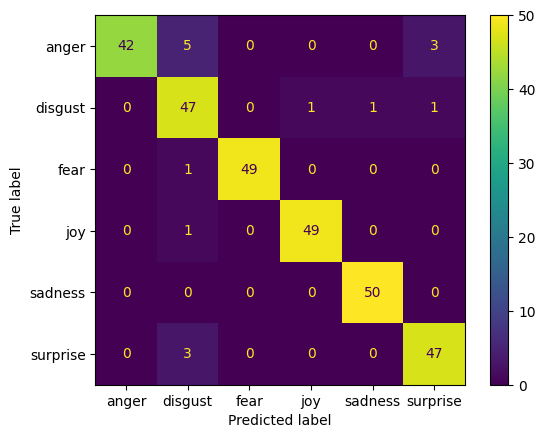

In [37]:
from sklearn import metrics

b_size = 1

data_loader = DataLoader(data, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)

predicts = []
corrects = []
mapping = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

with torch.no_grad():
  for indices, label in data_loader:
    indices = indices.cuda()
    label = label.cuda()

    # getting the text for the index-th video
    text_batch = []
    for index in indices:
      text = text_tensors[index].to(device)
      # if the text ends up being nothing
      if text_lengths[index] == 0:
        text[0] = dictionary['EMPTY']
        # dimensionality voodoo
        text_lengths[index] = 1
      text_batch.append(text)
    text_batch = torch.stack(text_batch)
    text_batch = text_batch.squeeze(1)

    # getting the spectrograms
    spect_batch = []
    for index in indices:
      spect = spect_tensors[index].to(device)
      spect.requires_grad = True
      spect_batch.append(spect)
    spect_batch = torch.stack(spect_batch)

    # getting all of the frames
    frame_batch = []
    for index in indices:
      frames = ds[index.cpu()].to(device)
      frames = frames.squeeze(0)
      frame_batch.append(frames)
    frame_batch = torch.stack(frame_batch)
    frame_batch = torch.transpose(frame_batch, 1, 2)

    # getting the text lengths
    textl = []
    for index in indices:
      textl.append(text_lengths[index])

    # output of the final NN on the super-tensor
    y_pred = model(spect_batch, text_batch, textl, frame_batch).to(device)

    prediction = y_pred.argmax(dim=1)

    predicts.append(prediction.item())
    corrects.append(label.item())

print(predicts)
print(corrects)

confucian = metrics.confusion_matrix(corrects, predicts)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confucian, display_labels = mapping)
cm_display.plot()
plt.show()

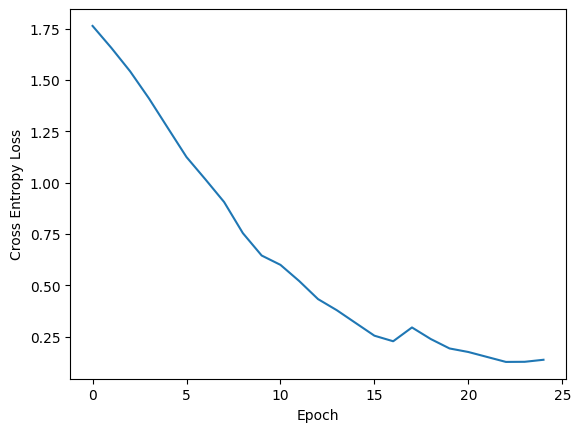

In [38]:
liszt = [1.7641, 1.6570, 1.5426, 1.4109, 1.2675, 1.1249, 1.0168, 0.9059, 0.7540, 0.6450, 0.5995, 0.5205, 0.4326, 0.3784, 0.3163, 0.2543, 0.2271, 0.2944, 0.2380, 0.1920, 0.1748, 0.1506, 0.1264, 0.1270, 0.1369]
plt.plot(liszt)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Save the Tensor (I do not want to run that cell ever again)

In [39]:
frame_tensors = torch.stack(frame_tensors)
torch.save(frame_tensors, "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/frame.pt")

NameError: name 'frame_tensors' is not defined